# VHS XMM / HSC WIDE W02 run

In this directory we are performing a VHS Ks selected processing of VHS J,Ks and HSC G,R,I,Z,Y PDR2 WIDE data.


In this notebook we plot the VHS tiles, over the tracts to patches to check coverages and then create the slurm jobs required to send the jobs to IRIS as arrays. We will also calculate times based on benchmarking on the SXDS field.

In [49]:
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#We are using a rings skymap
from lsst.geom import SpherePoint 
from lsst.geom import degrees
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

config = RingsSkyMapConfig()
#These config options are chose to be the same as HSC:
#https://github.com/lsst/obs_subaru/blob/master/config/hsc/makeSkyMap.py
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0/60 
config.pixelScale = 0.168
sm = RingsSkyMap(config)

## 1. Plot the regions and compute tile/patch numbers

In [93]:
vhs_ims = Table.read('../../dmu1/data/vhs_images_overview_20201102.csv')
hsc_ims = Table.read('../../dmu1/data/hsc_images_overview.csv')

In [94]:
hsc_ims['tract'] = [f.split('/')[14] for f in hsc_ims['file']]
hsc_ims['patch'] = [f.split('/')[15] for f in hsc_ims['file']]
hsc_ims['depth'] = [f.split('/')[11] for f in hsc_ims['file']]
hsc_ims['band'] = [f.split('-')[-3] for f in hsc_ims['file']]

In [95]:
def fileToType(filename):
    filetype = ''
    types = {
        'tile':'_tl.fit',
        'stack':'_st.fit',
    }
    for k,v in types.items():
        #print(k,v)
        if filename.endswith(v):
            filetype = k
  
    return filetype
vhs_ims['type'] = [fileToType(f) for f in vhs_ims['file']]

In [96]:
"Out of {} files in VHS there are {} stack images".format(len(vhs_ims),np.sum(vhs_ims['type']=='stack'))

'Out of 887732 files in VHS there are 204996 stack images'

In [97]:
vhs_near_xmm = vhs_ims['ra'] > 27
vhs_near_xmm &= vhs_ims['ra'] < 41
vhs_near_xmm &= vhs_ims['dec'] > -9
vhs_near_xmm &= vhs_ims['dec'] < 6

vhs_ims = vhs_ims[vhs_near_xmm]
"Out of {} VHS files near the XMM field there are {} stack images".format(len(vhs_ims), np.sum(vhs_ims['type']=='stack'))

'Out of 9364 VHS files near the XMM field there are 2226 stack images'

In [77]:
vhs_ims[:5]

file,ra,dec,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,filter,size,visit,exptime,hash,type
str96,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,int64,int64,int64,str32,str5
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20140924/v20140924_00594_st_conf.fit,90.622687,-11.03727,91.13695435105765,91.1389773490321,90.93602451122007,90.9374229533095,-10.39318967463107,-10.59013970480559,-10.392510506474606,-10.5898081855327,Ks,29911680,35932,7,9bcf2799115f98f0527f2b8e32d40c25,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20140924/v20140924_00607.fit,90.617,-11.04279,91.13230333392546,91.13388101866211,90.93719929367039,90.93818428198209,-10.399319196904885,-10.590665306756886,-10.398298247811736,-10.589972020856175,J,72506880,35945,15,bc57f6978105fb2d488edecf574f3d79,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20140924/v20140924_00573.fit,89.507317,-10.85962,90.02211525844324,90.0237473127461,89.82712440134513,89.82816636232153,-10.215997738668026,-10.407343399727566,-10.215032404049305,-10.40670588262657,Ks,89979840,35911,15,d1f202db145d984cc5cf16792cac473e,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20140924/v20140924_00608_st_conf.fit,90.622775,-10.85407,91.13669830129517,91.13874355273352,90.9358854908467,90.93730888741973,-10.210087373631694,-10.407085235741132,-10.209423978897208,-10.406769657371443,J,31271040,35946,15,37cbc1c3f7a32dab8a7f16bd56efe72e,
/home/ir-shir1/rds/rds-iris-ip005/data/private/VISTA/VHS/20140924/v20140924_00572_st_conf.fit,89.512975,-10.85407,90.02710271990243,90.02914393376061,89.82633514578113,89.82775450657641,-10.209631275879195,-10.406594577116618,-10.20895521109243,-10.406266170287486,Ks,29718720,35910,7,ff744a7eb18bc73e2f138f0b1a1fe459,


In [91]:
"There are {} stack files near XMM".format(np.sum(vhs_ims['type']=='stack'))

'There are 2226 stack files near XMM'

In [59]:
hsc_bands = ['G', 'R', 'I', 'Z', 'Y']
vista_bands = ['Y', 'J', 'H', 'Ks']

In [4]:
#https://hsc-release.mtk.nao.ac.jp/rsrc/pdr2/koike/survey-area/info/tracts_patches_W-w02.txt
patches_file = '../../dmu0/dmu0_HSC/tracts_patches/tracts_patches_W-w02.txt'

In [46]:
f = open(patches_file, 'r')
tracts = set()

for x in f:
    #print(x)
    
    
    if x.startswith('Tract'):
        #print(int(x.split(' ')[1]))
        tracts.add(int(x.split(' ')[1])) 
        #print('ewrter' , patches, int(x.split(' ')[1]))
    #n+=1
    #if n == 100:
       # break
    

In [66]:

for x in tracts:
    print(x, end=' ')

9731 9732 9733 9734 9735 9736 9737 9738 9739 9245 9246 9247 9248 9249 9250 9251 9252 9253 8761 8762 8763 8764 8765 8766 8767 8768 8769 8278 8279 8280 8281 8282 8283 8284 8285 8286 9973 9974 9975 9976 9977 9978 9979 9980 9981 9488 9489 9490 9491 9492 9493 9494 9495 9496 9003 9004 9005 9006 9007 9008 9009 9010 9011 8519 8520 8521 8522 8523 8524 8525 8526 8527 10215 10216 10217 10218 10219 10220 10221 10222 10223 

In [69]:
full_patch_dict = {}
band_dict = { hsc_bands[i]: {} for i in range(len(hsc_bands))}
for tract in tracts:
    full_patch_dict[tract] = [
        s for s in np.unique(np.array(hsc_ims[ (hsc_ims['tract'] == str(tract))]['patch']))
    ]
    for band in hsc_bands:
        band_dict[band][tract] = [
            s for s in np.unique(np.array(hsc_ims[
                (hsc_ims['tract'] == str(tract))
                & (hsc_ims['band'] == band)
            ]['patch']))
        ]

In [70]:
full_patch_dict

{9731: [],
 9732: [],
 9733: [],
 9734: [],
 9735: [],
 9736: [],
 9737: [],
 9738: [],
 9739: [],
 9245: [],
 9246: [],
 9247: [],
 9248: [],
 9249: [],
 9250: [],
 9251: [],
 9252: [],
 9253: [],
 8761: ['0,0',
  '0,1',
  '0,2',
  '0,3',
  '0,4',
  '0,5',
  '0,6',
  '0,7',
  '0,8',
  '1,0',
  '1,1',
  '1,2',
  '1,3',
  '1,4',
  '1,5',
  '1,6',
  '1,7',
  '1,8',
  '2,0',
  '2,1',
  '2,2',
  '2,3',
  '2,4',
  '2,5',
  '2,6',
  '2,7',
  '2,8',
  '3,0',
  '3,1',
  '3,2',
  '3,3',
  '3,4',
  '3,5',
  '3,6',
  '3,7',
  '3,8',
  '4,0',
  '4,1',
  '4,2',
  '4,5',
  '4,6',
  '4,7',
  '4,8',
  '5,0',
  '5,1',
  '5,7',
  '5,8',
  '6,0',
  '6,8'],
 8762: ['0,0',
  '0,1',
  '0,2',
  '0,3',
  '0,4',
  '0,5',
  '0,6',
  '0,7',
  '0,8',
  '1,0',
  '1,1',
  '1,2',
  '1,3',
  '1,4',
  '1,5',
  '1,6',
  '1,7',
  '1,8',
  '2,0',
  '2,1',
  '2,2',
  '2,3',
  '2,4',
  '2,5',
  '2,6',
  '2,7',
  '2,8',
  '3,0',
  '3,1',
  '3,2',
  '3,3',
  '3,4',
  '3,5',
  '3,6',
  '3,7',
  '3,8',
  '4,0',
  '4,1',
  '4,2

mkdir: figs: File exists


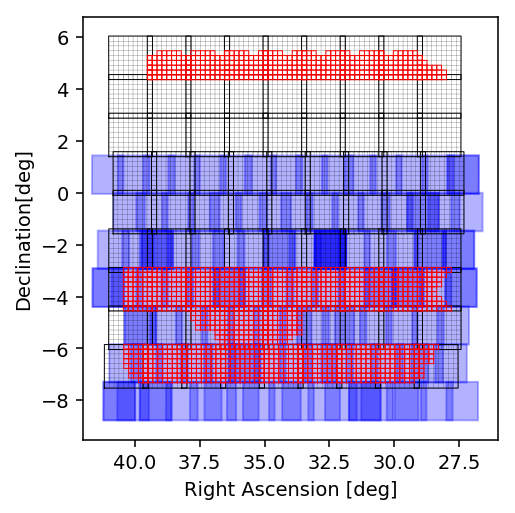

In [82]:
!mkdir figs
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for tract in tracts:
    vertices = sm.generateTract(tract).getVertexList()
    ra = [vertices[n][0].asDegrees() for n in np.mod(np.arange(5),4)]
    dec = [vertices[n][1].asDegrees() for n in np.mod(np.arange(5),4)]
    ax.plot(ra, dec, c = 'k', linewidth=0.5)
    for p in np.nditer(np.meshgrid(np.arange(0,9), np.arange(0,9))):
        #print(p[0], p[1])
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'k', alpha=0.5, linewidth=0.1)

#Plot patches on a band
band = 'all'
if band != 'all':
    d = band_dict[band]
else:
    d = full_patch_dict
for tract in d:
    for patch in d[tract]:
        #print(p[0], p[1])
        p = [int(i) for i in patch.split(',')]
        t = sm.generateTract(tract)
        vertices = t.getPatchInfo([p[0], p[1]]).getInnerSkyPolygon(t.getWcs()).getVertices()
        ra = [np.arctan(vertices[n][1]/vertices[n][0])* 180/np.pi for n in np.mod(np.arange(5),4)]
        #print(tract, ra)
        dec = [(vertices[n][2])* 180/np.pi for n in np.mod(np.arange(5),4)]
        ax.plot(ra, dec, c = 'r', alpha=1.0, linewidth=0.5)
        

v_band ='Ks'
for t in vhs_ims[(vhs_ims['type'] == 'tile') & (vhs_ims['filter'] == v_band) ]:

    ra = [t['ra_0_0'], t['ra_x_0'] , t['ra_x_y'] , t['ra_0_y'] , t['ra_0_0'] ]
    dec = [t['dec_0_0'], t['dec_x_0'] , t['dec_x_y'] , t['dec_0_y'] , t['dec_0_0'] ]
    
    ax.fill(ra,dec, c = 'b', alpha=0.3)
        
        
        

ax.axis('scaled')
ax.set_xlim([42, 26])
ax.set_xlabel('Right Ascension [deg]')
ax.set_ylabel('Declination [deg]')
fig.savefig('./figs/xmm_HSC-{}_tracts.pdf'.format(band), overwrite=True)
fig.savefig('./figs/xmm_HSC-{}_tracts.png'.format(band), overwrite=True)

In [86]:
#How many diferent exposure times for stacks are there
np.unique(vhs_ims[(vhs_ims['type'] == 'stack') & (vhs_ims['filter'] == v_band) ]['exptime'])

7
10


In [92]:
6*9*81

4374